## Bayesian linear regression

###### Assumptions: polynomial basis functions, scalar output, scalar input
###### Author: Rimple Sandhu, Carleton University; Email: rimple_sandhu@outlook.com

In [1]:
#!/usr/bin/python
import numpy as np
import numpy.linalg as la
import scipy.stats as st
import scipy.special as sc
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, math, sys

#### Model definition (basis functions)

In [2]:
polyPower = [0,1,2,3,4,5,6] # powers of polynomial basis
N = len(polyPower) # number of basis
def basisFun(Xth,ith):
    return Xth**polyPower[ith]

#### True coefficients and error precision (If known)

In [3]:
trueKnown =1 # 0 = dont plot true, 1= plot true 
Wtrue=[0]*N
Wtrue[0]=1
Wtrue[2]=1 
RHOtrue = 25

#### Known parameters

In [4]:
m0 = np.ones(N)*0 # prior mean
rho0 = 20 # prior meand for error precision
V0 = rho0*np.diag([1e+01]*N) # prior precision for w
a0 = rho0*0.1 # prior for rho Gamma(a0,b0), mean=a0/b0, var=a0/b0**2
b0 = 0.1  # prior for rho Gamma(a0,b0)
#pl.rcParams.update({'font.size':14})

#### Generate design matrix 

In [5]:
Yobs = np.loadtxt('Ydata.dat') 
Xobs = np.loadtxt('Xdata.dat')
M = len(Yobs)
Phi = np.zeros((M,N))
for i in range(0,M):
    for j in range(0,N):
        Phi[i,j] = basisFun(Xobs[i],j)

#### Function for multivariate t distribution pdf

In [6]:
def mymvtdist(x, mu, df, Sigma):
    nD = Sigma.shape[0]
    numerator = sc.gamma(1.0 * (nD + df) / 2.0)
    denominator = (sc.gamma(df/2)*np.power(df*np.pi,nD/2)*np.power(la.det(Sigma),0.5)*
                   np.power(1+(1/df)*np.dot(np.dot(x-mu,la.inv(Sigma)),(x-mu).T),(nD + df)/2))
    return 1.0*numerator/denominator

#### Bayesian linear regression update

In [7]:
V0inv = la.inv(V0)
VMLEinv  = np.matmul(np.transpose(Phi),Phi)
Vinv  = V0inv + VMLEinv
V  = la.inv(Vinv)
m  = np.matmul(V,np.matmul(V0inv,m0) + np.matmul(np.transpose(Phi),Yobs))
a  = a0 + M/2
b  = b0 + 0.5*(np.matmul(np.transpose(m0),np.matmul(V0inv,m0)) + \
               np.dot(Yobs,Yobs) - np.matmul(np.transpose(m),np.matmul(Vinv,m)))
Bmat = np.matmul(Phi,np.matmul(V0,np.transpose(Phi))) + np.identity(M)
tMat  = la.cholesky((b0/a0)*Bmat)
logEvid = np.log(mymvtdist(Yobs,np.matmul(Phi,m0),2*a0,tMat))

In [8]:
RHO0mean = a0/b0; RHO0mode = (a0-1)/b0; RHO0var = a0/(b0**2)
RHOmean = a/b;    RHOmode  = (a-1)/b;   RHOvar = a/(b**2)
P0 = V0/RHO0mode; P = V/RHOmode;
Wmle = np.matmul(la.inv(VMLEinv),np.matmul(np.transpose(Phi),Yobs))
resNormMLE = la.norm(Yobs-np.matmul(Phi,Wmle))
resNormMAP = la.norm(Yobs-np.matmul(Phi,m))
RHOmle = (M-N)/(resNormMLE**2)
u1,s1,v1 = la.svd(VMLEinv)
u2,s2,v2 = la.svd(Vinv)

In [9]:
print('  i   Wprior     Wmle      Wmap   PRECprior   PRECmle   PRECmap  SVD(PRECmle) SVD(PRECmap)')
for i in range(0,N):
    print("{0:3d}{1:10.2e}{2:10.2e}{3:10.2e}{4:10.2e}{5:10.2e}{6:10.2e}{7:12.2e}{8:12.2e}".format(\
        int(i),m0[i],Wmle[i],m[i],V0inv[i,i]*RHO0mode,VMLEinv[i,i]*RHOmle,Vinv[i,i]*RHOmode,s1[i],s2[i]))
print("rho{0:10.2e}{1:10.2e}{2:10.2e}{3:10.2e}     -    {4:10.2e}".format(\
        RHO0mode,RHOmle,RHOmode,1/RHO0var,1/RHOvar))
print("\n           Cond no.   Rank")
print("PRECmle: {0:10.2e}{1:5d}/{2:2d}".format(la.cond(VMLEinv), la.matrix_rank(VMLEinv),N))
print("PRECmap: {0:10.2e}{1:5d}/{2:2d}".format(la.cond(Vinv), la.matrix_rank(Vinv),N))
print("\na/a0: {0:12.2e}/{1:12.2e}".format(a,a0))
print("b/b0: {0:12.2e}/{1:12.2e}".format(b,b0))
print("\nLogEvid: {0:12.2e}".format(logEvid))
print("ResNormMLE: {0:9.2e}\nResNormMAP: {1:9.2e}".format(resNormMLE,resNormMAP))

  i   Wprior     Wmle      Wmap   PRECprior   PRECmle   PRECmap  SVD(PRECmle) SVD(PRECmap)
  0  0.00e+00  1.19e+00  1.15e+00  5.00e-02  1.40e+03  1.37e+03    8.44e+01    8.44e+01
  1  0.00e+00  3.04e-01 -1.01e+00  5.00e-02  4.71e+02  4.61e+02    1.43e+01    1.43e+01
  2  0.00e+00 -1.98e+01  2.41e+00  5.00e-02  2.88e+02  2.82e+02    1.15e+00    1.15e+00
  3  0.00e+00  9.40e+01  4.06e-01  5.00e-02  2.10e+02  2.06e+02    5.59e-02    6.09e-02
  4  0.00e+00 -1.64e+02 -8.96e-01  5.00e-02  1.67e+02  1.63e+02    1.69e-03    6.69e-03
  5  0.00e+00  1.24e+02 -7.09e-01  5.00e-02  1.39e+02  1.36e+02    2.89e-05    5.03e-03
  6  0.00e+00 -3.45e+01  5.11e-01  5.00e-02  1.20e+02  1.18e+02    2.16e-07    5.00e-03
rho  1.00e+01  2.80e+01  2.74e+01  5.00e-03     -      3.34e-02

           Cond no.   Rank
PRECmle:   3.90e+08    7/ 7
PRECmap:   1.69e+04    7/ 7

a/a0:     2.70e+01/    2.00e+00
b/b0:     9.50e-01/    1.00e-01

LogEvid:    -7.46e+00
ResNormMLE:  1.24e+00
ResNormMAP:  1.28e+00


#### Plot parameter marginal pdfs

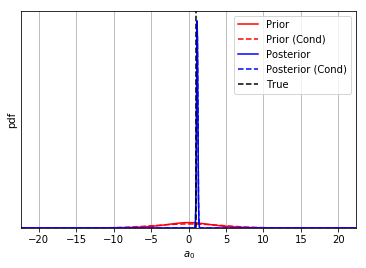

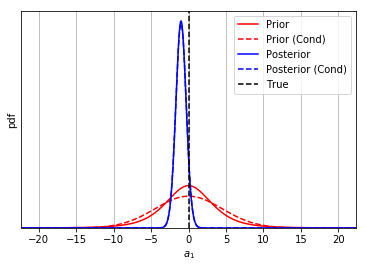

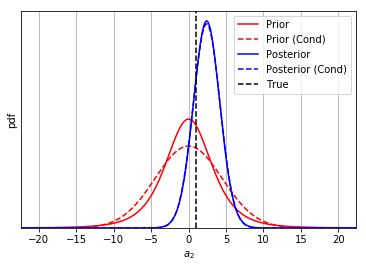

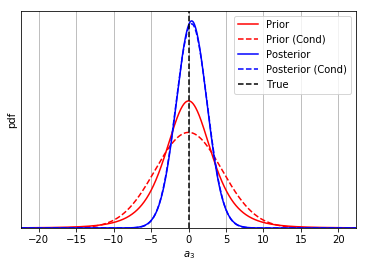

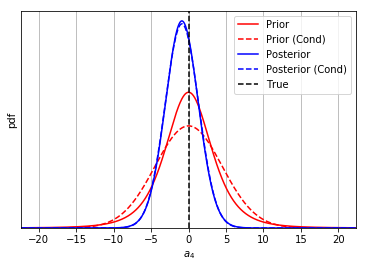

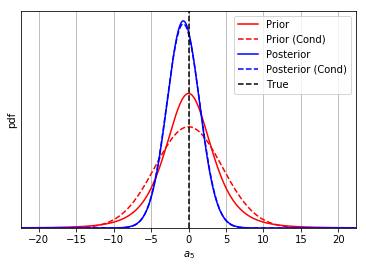

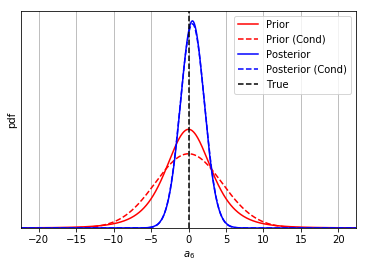

In [10]:
Wlim = [-6,6]  # xlim for plotting pdf plots
Ngrid = 1000  # density for grid generation in X
pscale=5  # for automatic bound calculation for pdf plots 
for i in range(0,N):
    P
    Wpriormin = m0[i]-pscale*np.sqrt(P0[i,i])
    Wpriormax = m0[i]+pscale*np.sqrt(P0[i,i])
    Wpostmin = m[i]-pscale*np.sqrt(P[i,i])
    Wpostmax = m[i]+pscale*np.sqrt(P[i,i])
    Wlim = [min(Wpriormin,Wpostmin),max(Wpostmax,Wpriormax)] 
    #Wlim = [Wpostmin,Wpostmax] 
    Wgrid = np.linspace(Wlim[0],Wlim[1],Ngrid)
    Wprior = st.t.pdf(Wgrid,2*a0,m0[i],np.sqrt(V0[i,i]/RHO0mean))
    Wpost = st.t.pdf(Wgrid,2*a,m[i],np.sqrt(V[i,i]/RHOmean))
    WCprior = st.multivariate_normal.pdf(Wgrid,m0[i],P0[i,i])
    WCpost = st.multivariate_normal.pdf(Wgrid,m[i],P[i,i])
    fig = plt.figure(i+1)
    plt.plot(Wgrid,Wprior,'r-',label='Prior')
    plt.plot(Wgrid,WCprior,'r--',label='Prior (Cond)')
    plt.plot(Wgrid,Wpost,'b-',label='Posterior')
    plt.plot(Wgrid,WCpost,'b--',label='Posterior (Cond)')
    plt.grid(True)
    plt.yticks([])
    plt.xlim(Wlim)
    ax = plt.gca(); Ylim = ax.get_ylim()
    if trueKnown == 1: plt.plot([Wtrue[i],Wtrue[i]],[0,Ylim[1]],'k--',label='True')
    plt.ylim([0,Ylim[1]])
    plt.xlabel(r'$a_{'+str(i)+'}$')
    plt.ylabel('pdf')
    plt.legend(loc='best', numpoints = 1)
    plt.savefig('2_BLR_mpdf'+str(i)+'.eps',bbox_inches='tight')    

#### Plot marginal pdf of error precision rho

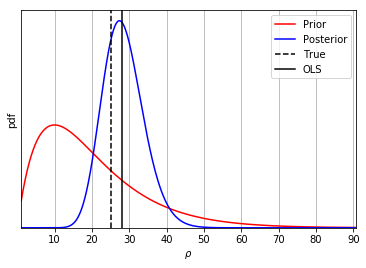

In [11]:
RHO0max = RHO0mean + pscale*np.sqrt(RHO0var)
RHOmax= RHOmean + pscale*np.sqrt(RHOvar)
RHO0min = RHO0mean - pscale*np.sqrt(RHO0var)
RHOmin= RHOmean - pscale*np.sqrt(RHOvar)
RHOlim = [max(0,RHO0min,RHOmin),max(RHO0max,RHOmax)]
RHOgrid = np.linspace(RHOlim[0],RHOlim[1],1000)
RHOprior = st.gamma.pdf(RHOgrid,a0,0,1/b0)
RHOpost = st.gamma.pdf(RHOgrid,a,0,1/b)
fig = plt.figure(N+1)
plt.plot(RHOgrid,RHOprior,'r-',label='Prior')
plt.plot(RHOgrid,RHOpost,'b-',label='Posterior')
plt.grid(True)
plt.yticks([])
plt.xlim(RHOlim)
ax = plt.gca(); Ylim = ax.get_ylim()
if trueKnown == 1: plt.plot([RHOtrue,RHOtrue],[0,Ylim[1]],'k--',label='True')
plt.plot([RHOmle,RHOmle],[0,Ylim[1]],'k-',label='OLS')
plt.ylim([0,Ylim[1]])
plt.xlabel(r'$\rho$')
plt.ylabel('pdf')
plt.legend(loc='best', numpoints = 1)
plt.savefig('2_BLR_rho.pdf',bbox_inches='tight')

#### Plot model predictions vs true response

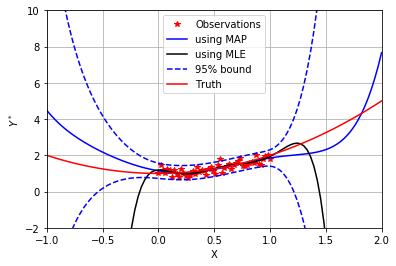

In [12]:
Xextra = 1 # width for extrapolation
Yrnge = [-2,10] 
Mnew = 100
Xrnge = [min(Xobs)-Xextra,max(Xobs)+Xextra]
Xnew = np.linspace(Xrnge[0],Xrnge[1],Mnew)
PhiNew = np.zeros((Mnew,N))
for i in range(0,Mnew):
    for j in range(0,N):
        PhiNew[i,j] = basisFun(Xnew[i],j)
Yvar = np.matmul(PhiNew,np.matmul(P,np.transpose(PhiNew))) + np.identity(Mnew)/RHOmode
Ymap = np.matmul(PhiNew,m)
Ymle = np.matmul(PhiNew,Wmle)
fig = plt.figure(N+1)
plt.plot(Xobs,Yobs,'r*',label='Observations')
plt.plot(Xnew,Ymap,'b-',label='using MAP')
plt.plot(Xnew,Ymle,'k-',label='using MLE')
plt.plot(Xnew,Ymap+2*np.sqrt(np.diag(Yvar)),'b--',label='95% bound')
plt.plot(Xnew,Ymap-2*np.sqrt(np.diag(Yvar)),'b--')
if trueKnown ==1:
    Ytrue = np.matmul(PhiNew,np.transpose(Wtrue))
    plt.plot(Xnew,Ytrue,'r-',label='Truth')
plt.grid(True)
plt.ylabel(r'$Y^*$')
plt.xlabel('X')
plt.ylim(Yrnge)
plt.xlim([Xrnge[0],Xrnge[1]])
plt.legend(loc='best', numpoints = 1)
plt.savefig('2_BLR_pred.eps',bbox_inches='tight')